# Predicting Wine Quality

We want to develop a predictive model that can accurately assess or predict the quality score of a wine based solely on its measurable physicochemical properties.

we will be using the [Wine Quality Dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) from the UCI Machine Learning Repository since it is suitable for our goal


In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [59]:
red = pd.read_csv("winequality-red.csv",sep=';')
white = pd.read_csv("winequality-white.csv",sep=';')

## Dataset Features

The wine quality dataset contains the following physicochemical features:

- **fixed acidity**: The amount of non-volatile acids (tartaric, malic, citric) in wine, measured in g/dm³. These acids contribute to the wine's tartness and stability.

- **volatile acidity**: The amount of acetic acid in wine, measured in g/dm³. High levels can indicate wine spoilage and result in a vinegar-like taste.

- **citric acid**: The amount of citric acid present, measured in g/dm³. It adds freshness and flavor to wines, though typically found in small quantities.

- **residual sugar**: The amount of sugar remaining after fermentation stops, measured in g/dm³. Determines whether a wine is dry, off-dry, or sweet.

- **chlorides**: The amount of salt in the wine, measured in g/dm³. Contributes to the wine's taste and mouthfeel.

- **free sulfur dioxide**: The amount of free SO₂ in mg/dm³. Acts as an antimicrobial and antioxidant agent to prevent spoilage and oxidation.

- **total sulfur dioxide**: The total amount of SO₂ (free + bound forms) in mg/dm³. Includes both free and bound sulfur dioxide used as a preservative.

- **density**: The density of the wine, measured in g/cm³. Related to the sugar and alcohol content; typically ranges from 0.99 to 1.01 g/cm³.

- **pH**: The measure of acidity/alkalinity on a scale of 0-14. Most wines have a pH between 2.9 and 3.9. Lower pH indicates higher acidity.

- **sulphates**: The amount of potassium sulphate in g/dm³. Added as an antioxidant and antimicrobial agent, similar to sulfur dioxide.

- **alcohol**: The alcohol content of the wine, measured as % by volume. Typically ranges from 8-15% and contributes to body, sweetness, and flavor intensity.

- **quality**: The target variable representing wine quality, scored by expert tasters on a scale of 0-10 (though typically ranges from 3-9 in practice).

- **type**: The type of wine (red or white), added during data preprocessing to distinguish between the two wine categories.

## Dataset Structure & Quality

Let's start by examining the basic structure of our datasets.


In [60]:
# Size & Schema: rows, columns, data types
print("=" * 60)
print("RED WINE DATASET")
print("=" * 60)
print(f"Shape: {red.shape[0]} rows × {red.shape[1]} columns")
print(f"\nData Types:")
print(red.dtypes)
print(f"\nBasic Statistics:")
print(red.describe())

print("\n" + "=" * 60)
print("WHITE WINE DATASET")
print("=" * 60)
print(f"Shape: {white.shape[0]} rows × {white.shape[1]} columns")
print(f"\nData Types:")
print(white.dtypes)
print(f"\nBasic Statistics:")
print(white.describe())

RED WINE DATASET
Shape: 1599 rows × 12 columns

Data Types:
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Basic Statistics:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000      

## Checking For Missing Values

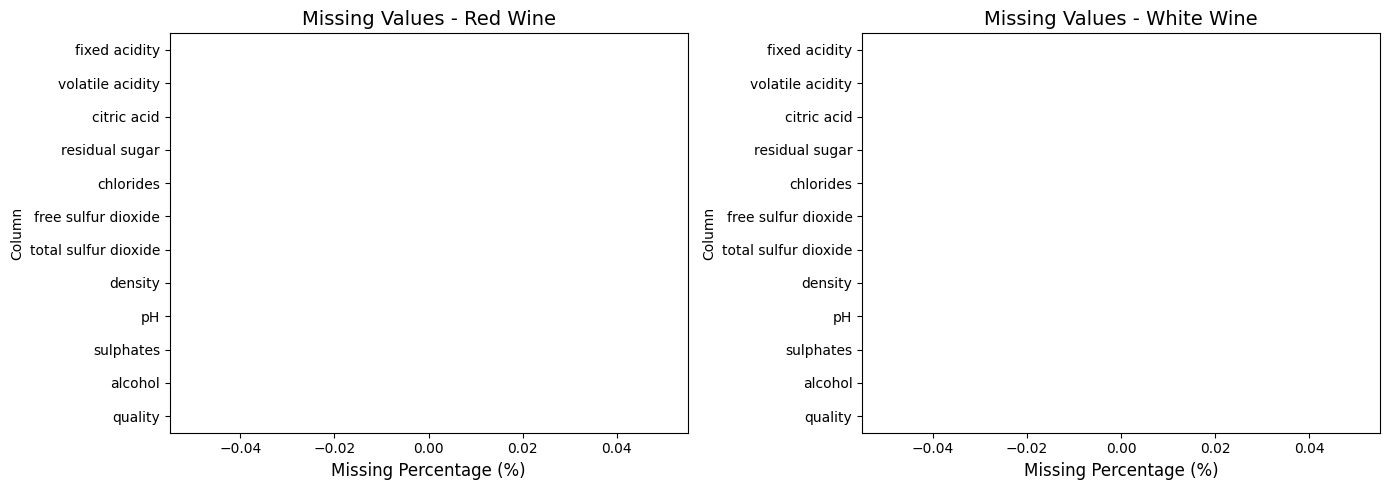

In [61]:
# Visual representation of missing values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Red wine missing values
missing_red = red.isnull().sum()
missing_red_pct = (missing_red / len(red)) * 100
missing_red_df = pd.DataFrame({
    'Column': missing_red.index,
    'Missing Count': missing_red.values,
    'Missing %': missing_red_pct.values
})

sns.barplot(data=missing_red_df, x='Missing %', y='Column', ax=axes[0], hue='Column', palette='Reds_r', legend=False)
axes[0].set_title('Missing Values - Red Wine', fontsize=14)
axes[0].set_xlabel('Missing Percentage (%)', fontsize=12)

# White wine missing values
missing_white = white.isnull().sum()
missing_white_pct = (missing_white / len(white)) * 100
missing_white_df = pd.DataFrame({
    'Column': missing_white.index,
    'Missing Count': missing_white.values,
    'Missing %': missing_white_pct.values
})

sns.barplot(data=missing_white_df, x='Missing %', y='Column', ax=axes[1], hue='Column', palette='Blues_r', legend=False)
axes[1].set_title('Missing Values - White Wine', fontsize=14)
axes[1].set_xlabel('Missing Percentage (%)', fontsize=12)

plt.tight_layout()
plt.show()

## Comprehensive Univariate Analysis

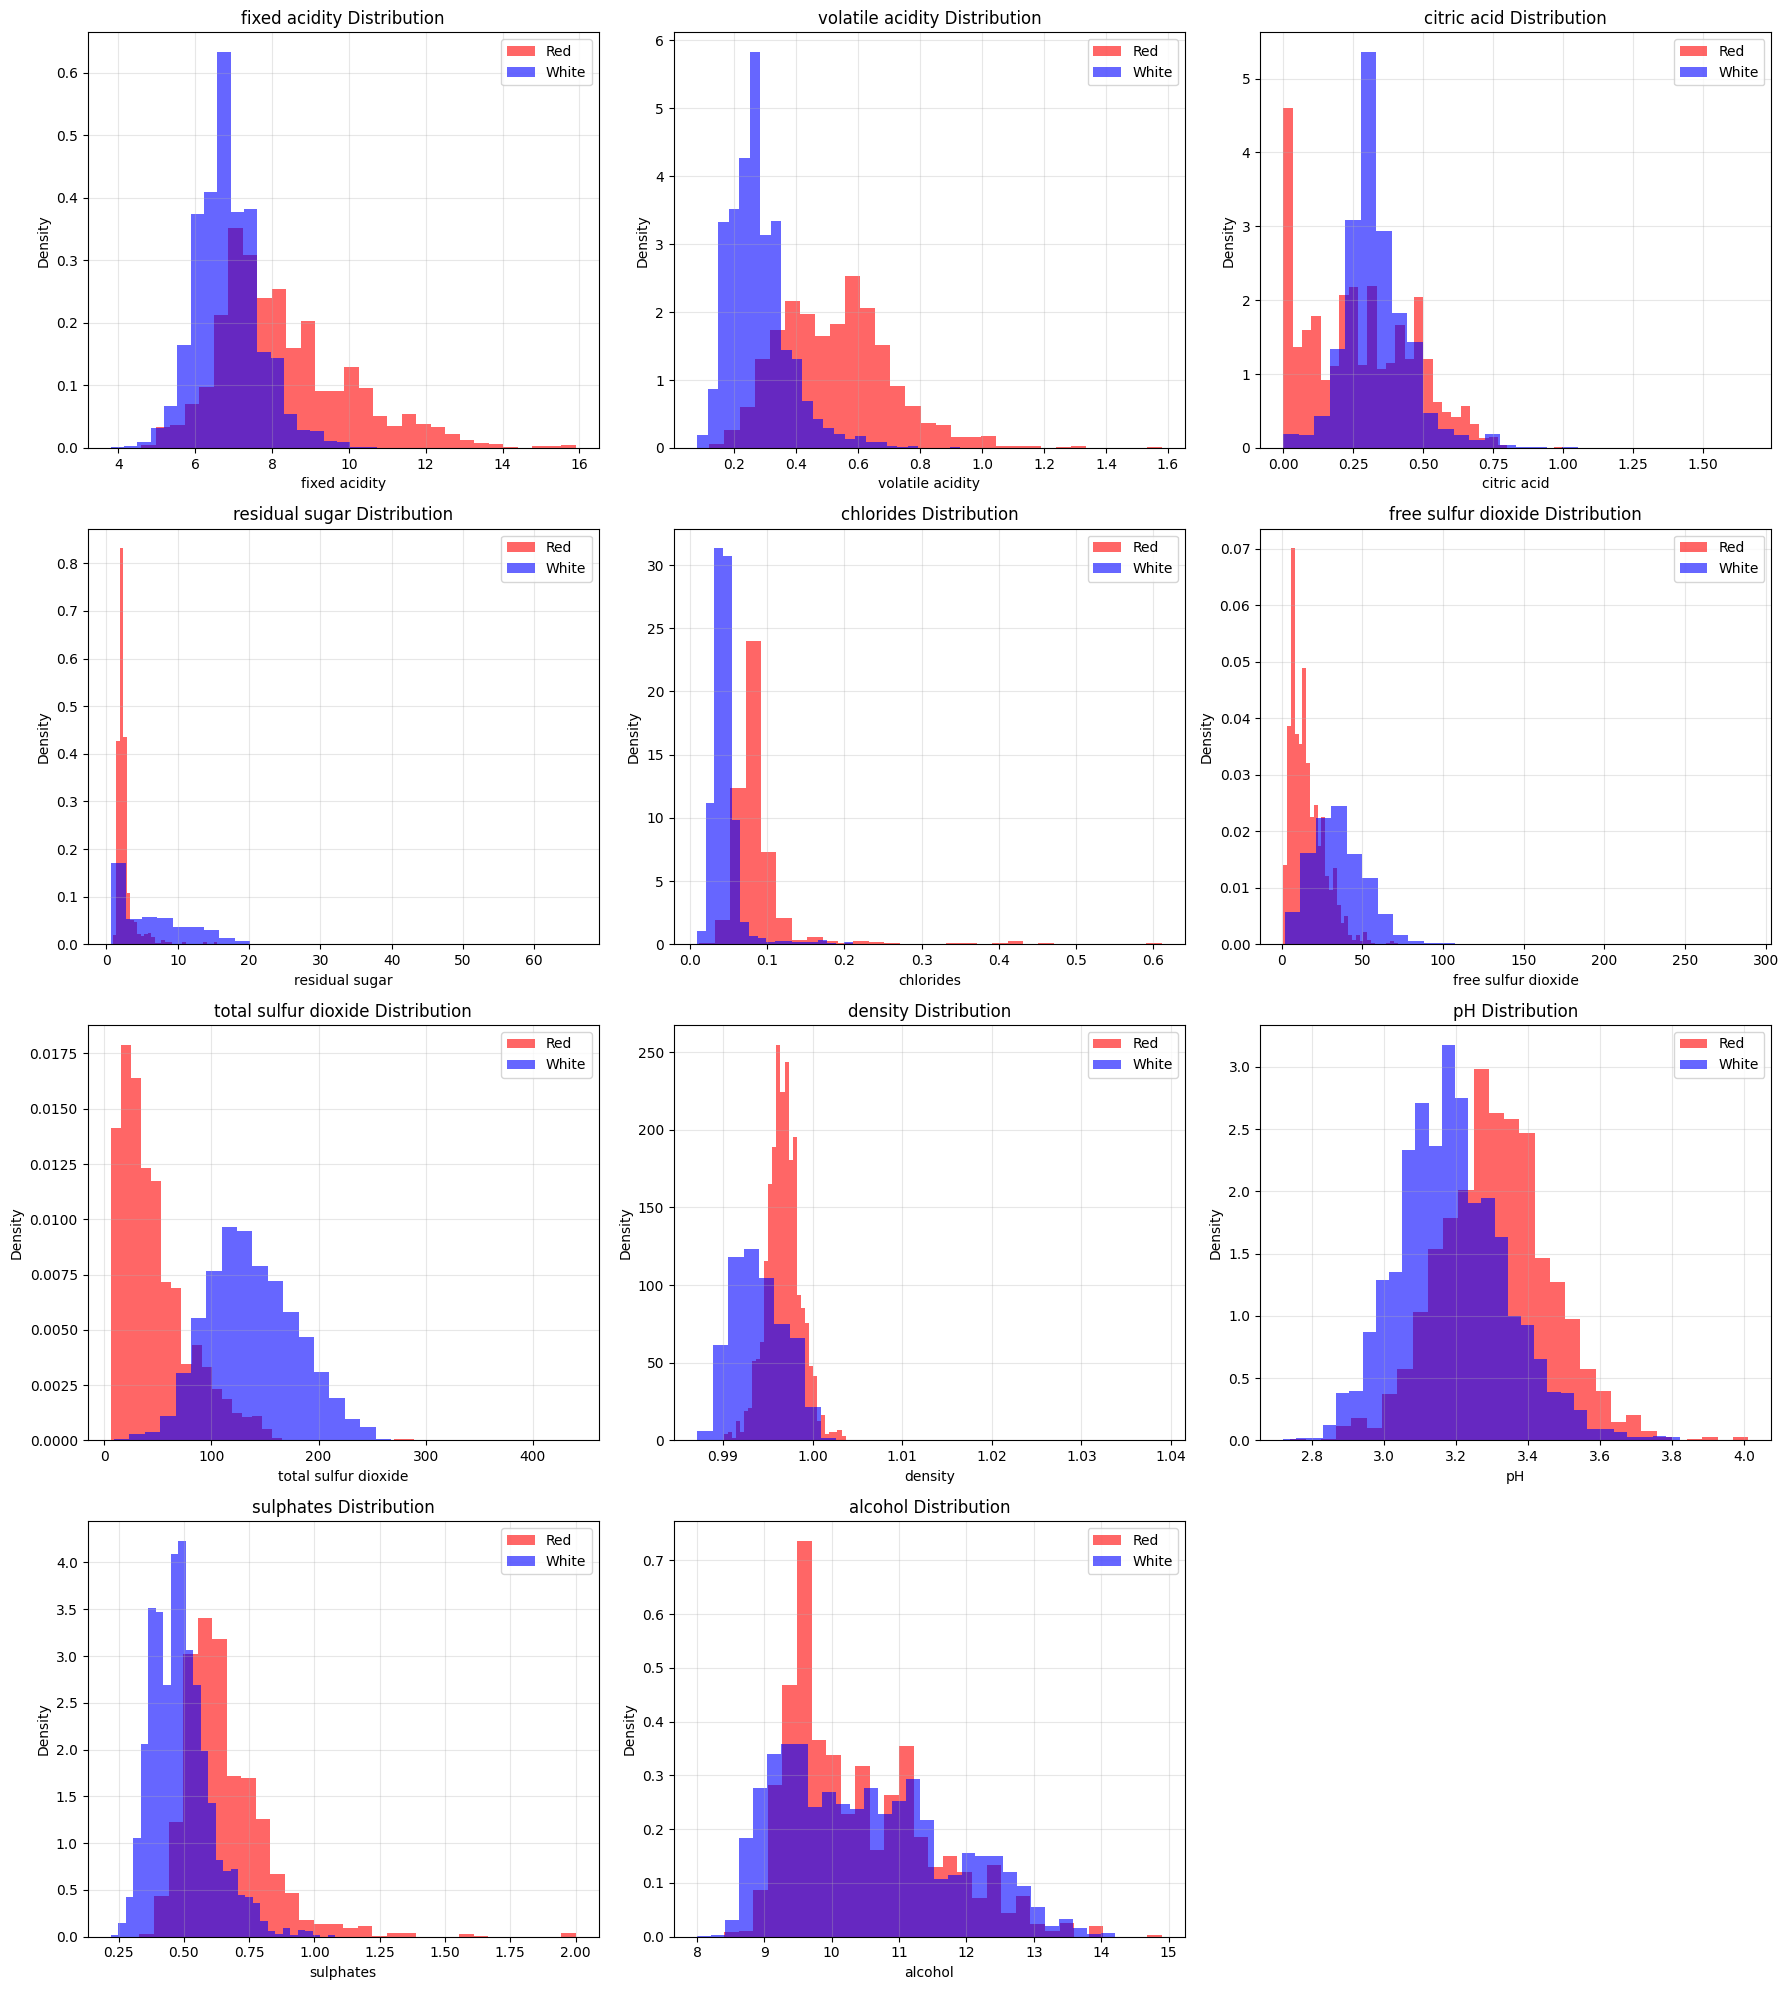

In [62]:
# Get all numeric features (excluding quality for now)
numeric_features = [col for col in red.columns if col != 'quality' and red[col].dtype in ['float64', 'int64']]

# Create comprehensive univariate plots
n_features = len(numeric_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(numeric_features):
    # Histogram
    axes[idx].hist(red[feature], bins=30, alpha=0.6, label='Red', color='red', density=True)
    axes[idx].hist(white[feature], bins=30, alpha=0.6, label='White', color='blue', density=True)
    axes[idx].set_title(f'{feature} Distribution', fontsize=12)
    axes[idx].set_xlabel(feature, fontsize=10)
    axes[idx].set_ylabel('Density', fontsize=10)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


## Identifying Outliers

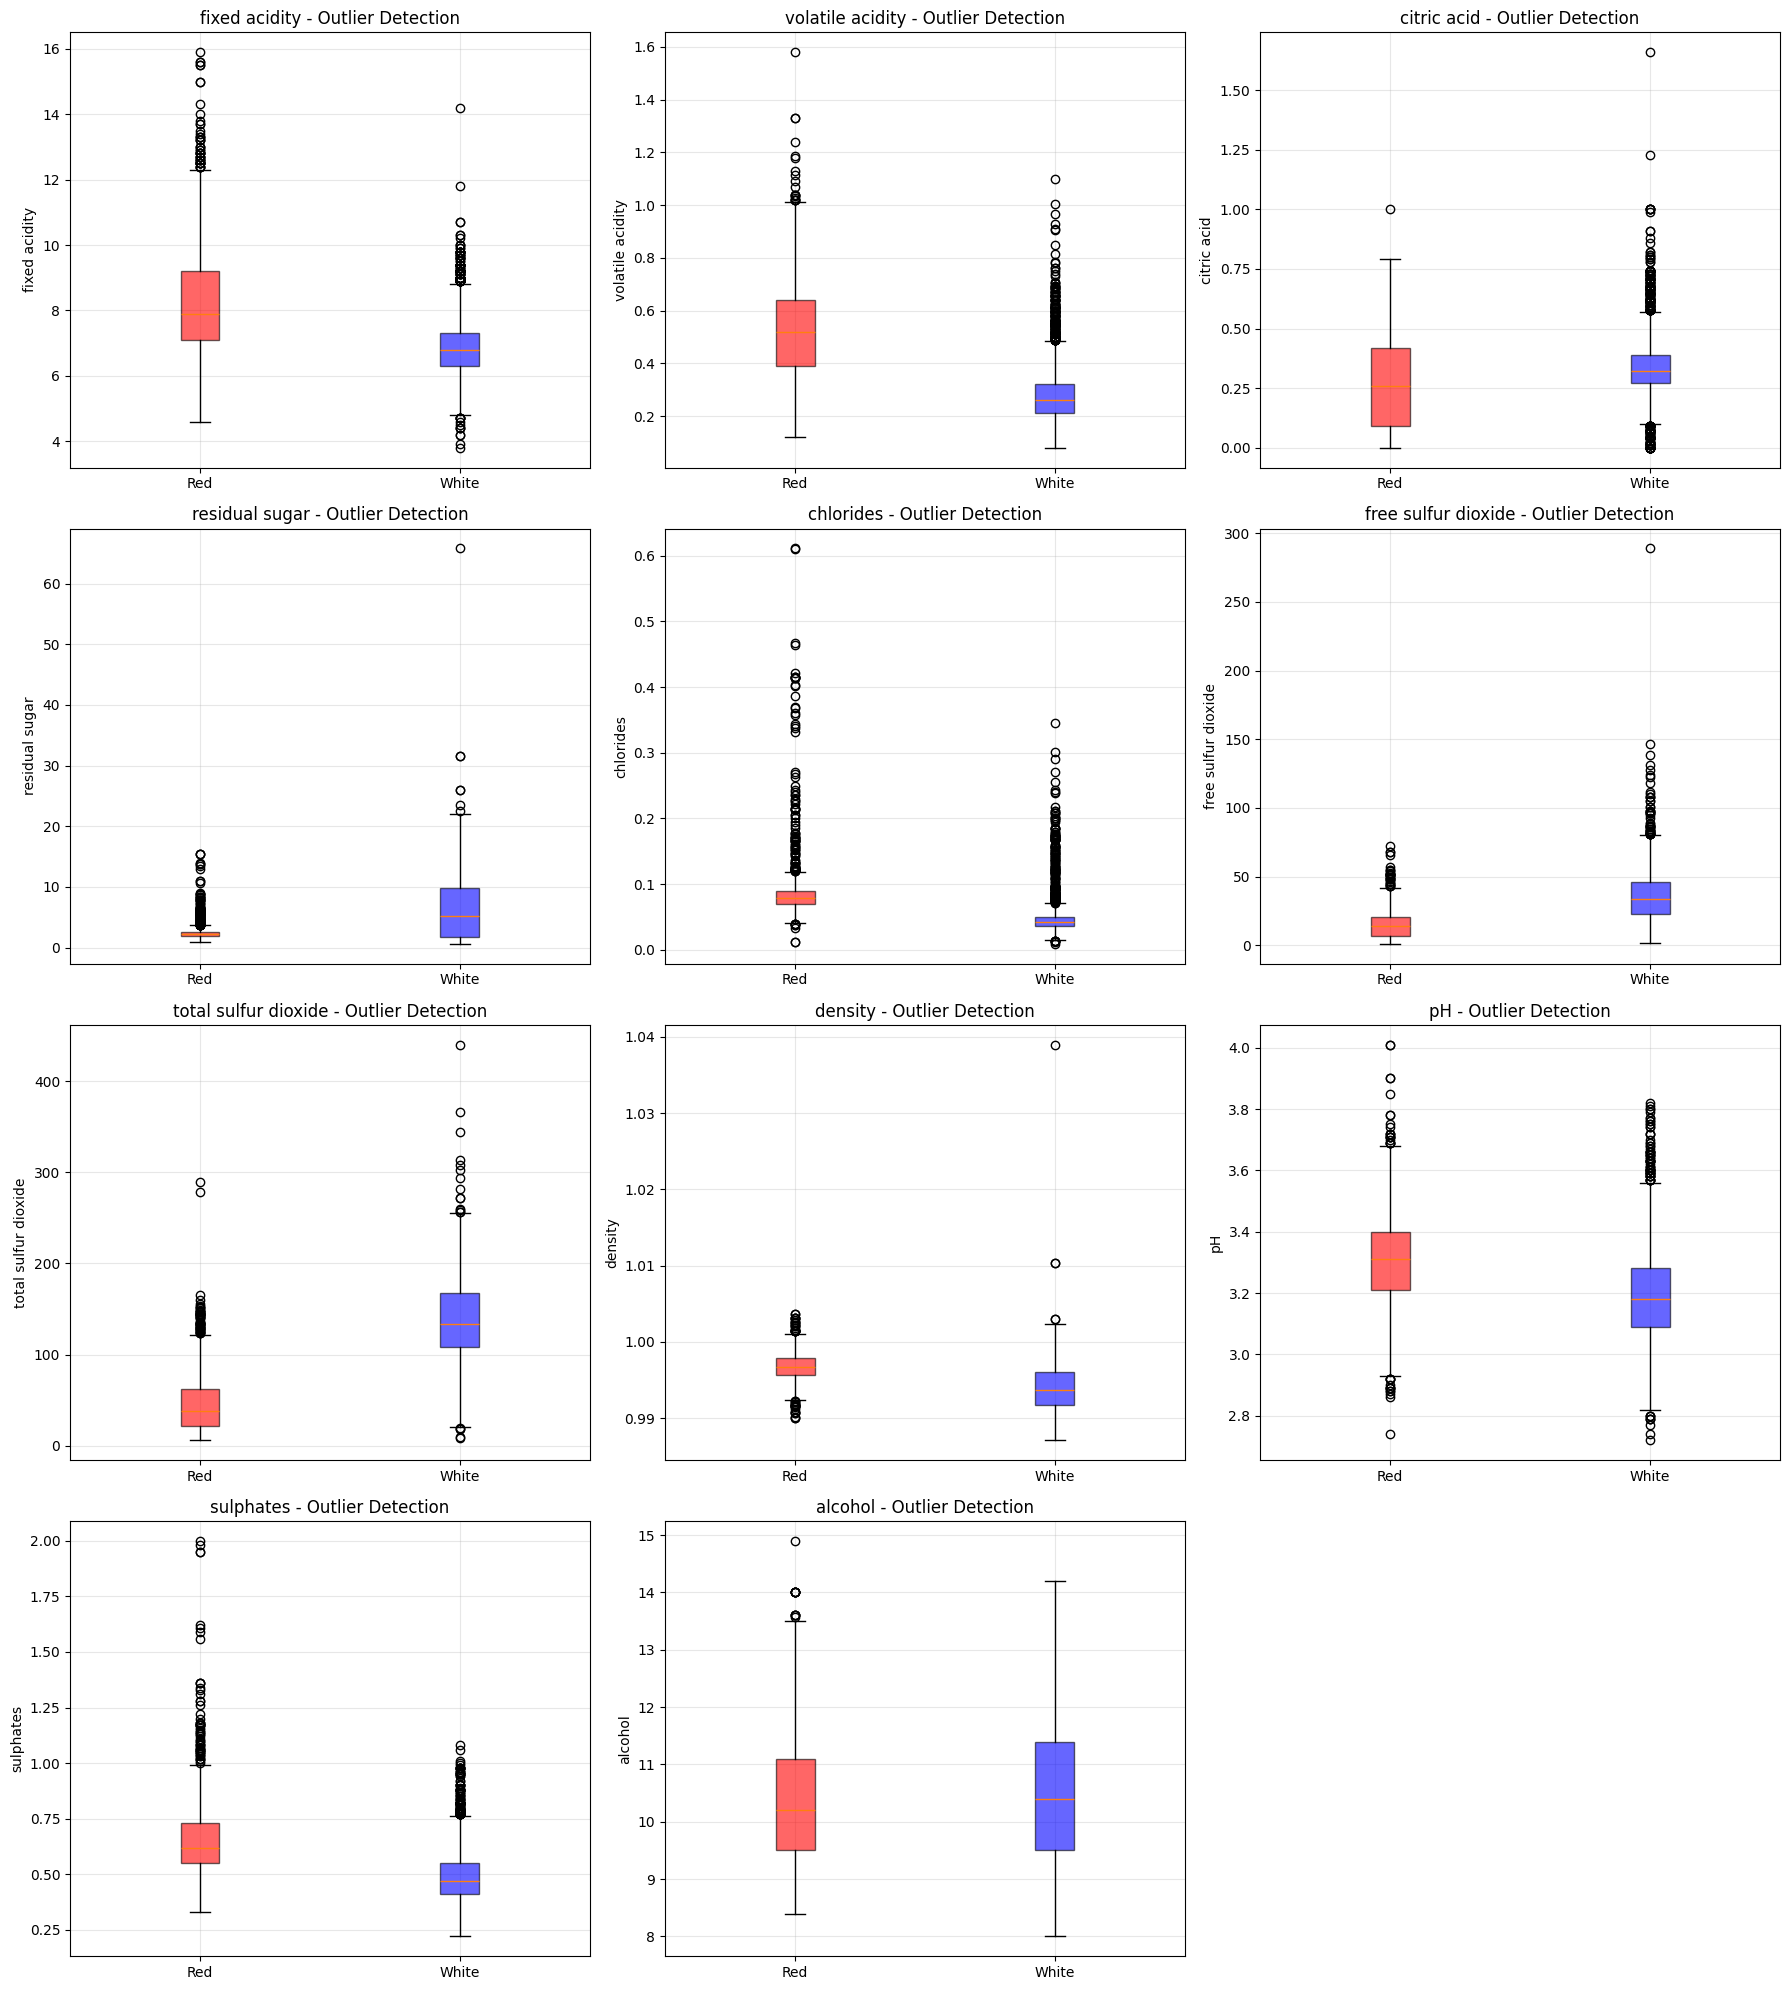

In [63]:
# Boxplots for all numeric features to identify outliers
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(numeric_features):
    data_to_plot = [red[feature], white[feature]]
    bp = axes[idx].boxplot(data_to_plot, tick_labels=['Red', 'White'], patch_artist=True)
    bp['boxes'][0].set_facecolor('red')
    bp['boxes'][0].set_alpha(0.6)
    bp['boxes'][1].set_facecolor('blue')
    bp['boxes'][1].set_alpha(0.6)
    axes[idx].set_title(f'{feature} - Outlier Detection', fontsize=12)
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## Full Correlation Matrix

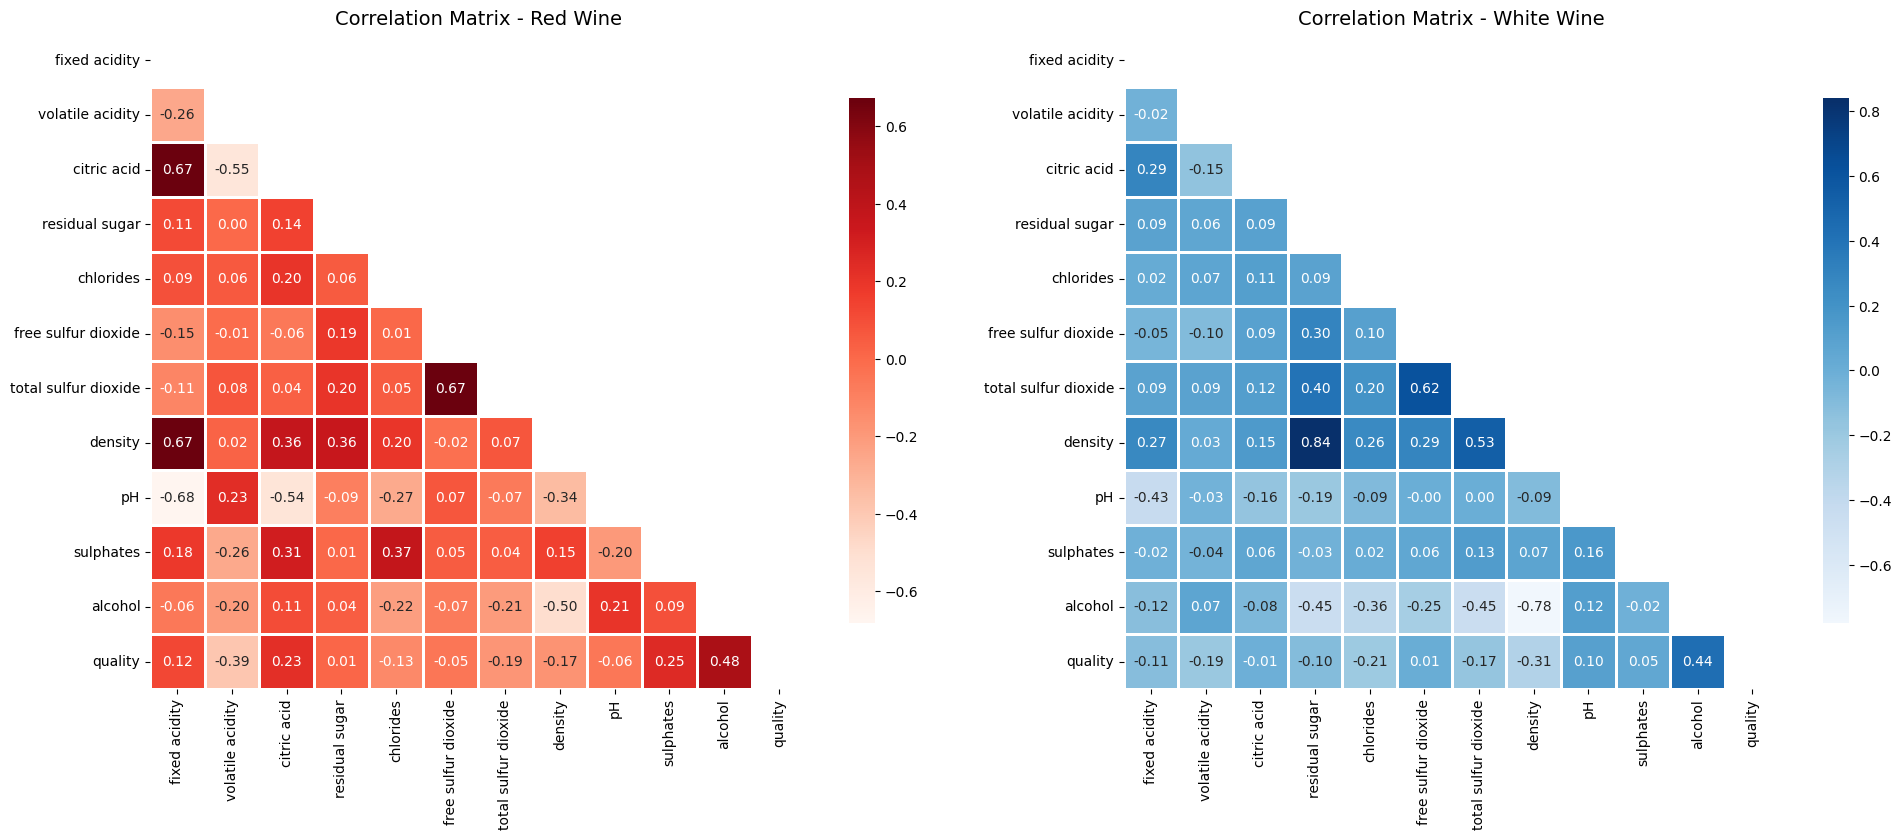

In [64]:
# Full correlation matrix heatmap for red wine
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Red wine correlation matrix
corr_red = red.corr()
mask_red = np.triu(np.ones_like(corr_red, dtype=bool))
sns.heatmap(corr_red, mask=mask_red, annot=True, fmt='.2f', cmap='Reds', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Correlation Matrix - Red Wine', fontsize=14)

# White wine correlation matrix
corr_white = white.corr()
mask_white = np.triu(np.ones_like(corr_white, dtype=bool))
sns.heatmap(corr_white, mask=mask_white, annot=True, fmt='.2f', cmap='Blues', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[1])
axes[1].set_title('Correlation Matrix - White Wine', fontsize=14)

plt.tight_layout()
plt.show()

## Correlation with Quality - Feature Importance Analysis

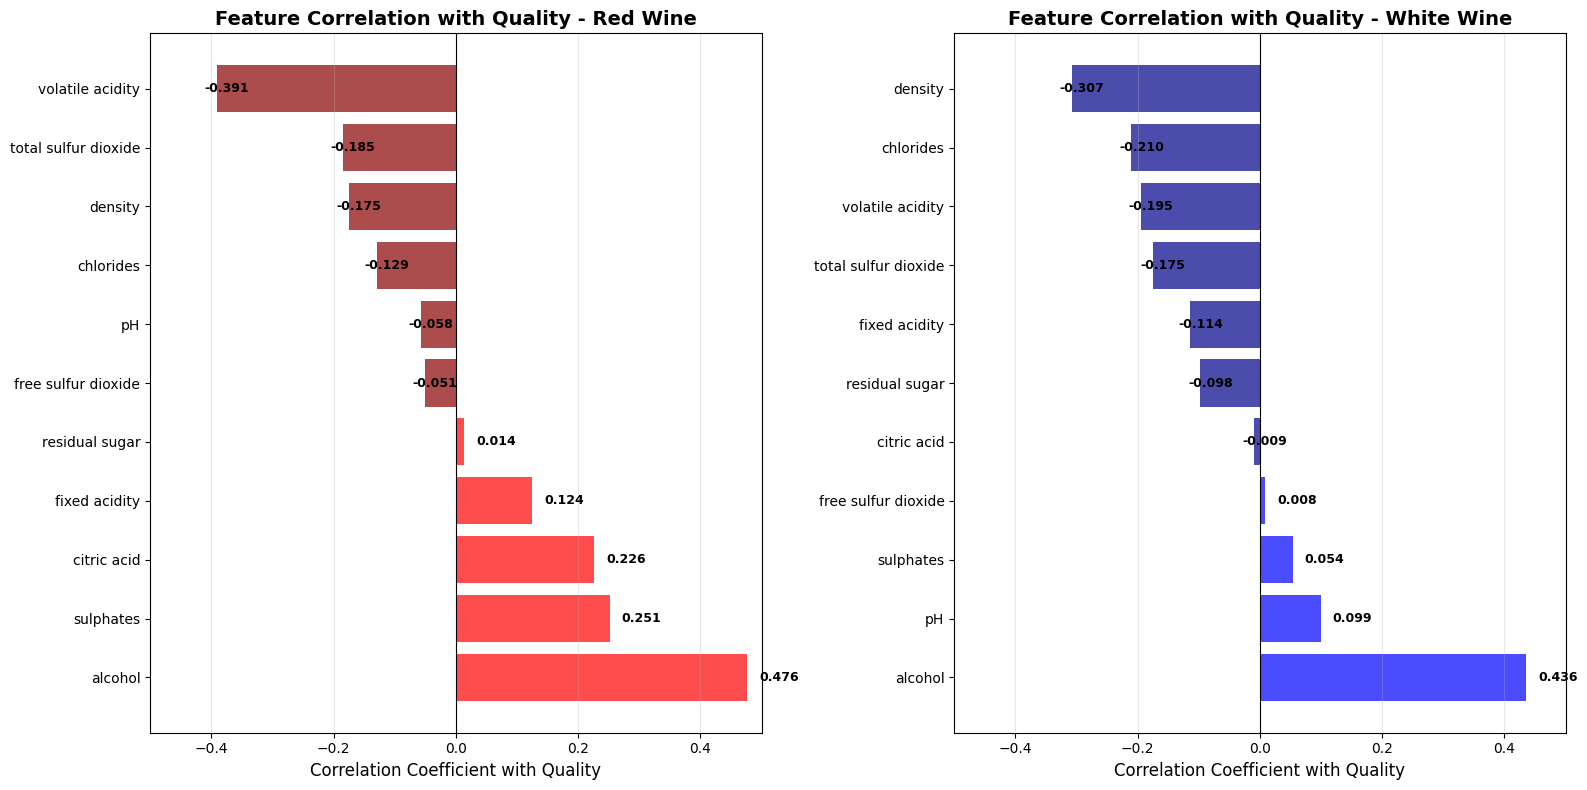

CORRELATION WITH QUALITY - SUMMARY

RED WINE - Top Features Correlated with Quality:
------------------------------------------------------------
  alcohol                  :  0.4762 (positive correlation)
  sulphates                :  0.2514 (positive correlation)
  citric acid              :  0.2264 (positive correlation)
  fixed acidity            :  0.1241 (positive correlation)
  residual sugar           :  0.0137 (positive correlation)

RED WINE - Bottom Features Correlated with Quality:
------------------------------------------------------------
  pH                       : -0.0577 (negative correlation)
  chlorides                : -0.1289 (negative correlation)
  density                  : -0.1749 (negative correlation)
  total sulfur dioxide     : -0.1851 (negative correlation)
  volatile acidity         : -0.3906 (negative correlation)

WHITE WINE - Top Features Correlated with Quality:
------------------------------------------------------------
  alcohol                  

In [77]:
# Calculate correlation with quality for each feature
# This provides a focused view on which features are most related to wine quality

# Red wine correlations with quality
corr_red_quality = red.corr()['quality'].drop('quality').sort_values(ascending=False)

# White wine correlations with quality
corr_white_quality = white.corr()['quality'].drop('quality').sort_values(ascending=False)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Red wine correlation with quality
colors_red = ['red' if x > 0 else 'darkred' for x in corr_red_quality.values]
axes[0].barh(corr_red_quality.index, corr_red_quality.values, color=colors_red, alpha=0.7)
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[0].set_xlabel('Correlation Coefficient with Quality', fontsize=12)
axes[0].set_title('Feature Correlation with Quality - Red Wine', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].set_xlim(-0.5, 0.5)

# Add value labels on bars
for i, (idx, val) in enumerate(corr_red_quality.items()):
    axes[0].text(val + 0.02 if val > 0 else val - 0.02, i, f'{val:.3f}', 
                 va='center', fontsize=9, fontweight='bold')

# White wine correlation with quality
colors_white = ['blue' if x > 0 else 'darkblue' for x in corr_white_quality.values]
axes[1].barh(corr_white_quality.index, corr_white_quality.values, color=colors_white, alpha=0.7)
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_xlabel('Correlation Coefficient with Quality', fontsize=12)
axes[1].set_title('Feature Correlation with Quality - White Wine', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].set_xlim(-0.5, 0.5)

# Add value labels on bars
for i, (idx, val) in enumerate(corr_white_quality.items()):
    axes[1].text(val + 0.02 if val > 0 else val - 0.02, i, f'{val:.3f}', 
                 va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 80)
print("CORRELATION WITH QUALITY - SUMMARY")
print("=" * 80)
print("\nRED WINE - Top Features Correlated with Quality:")
print("-" * 60)
for feature, corr in corr_red_quality.head(5).items():
    direction = "positive" if corr > 0 else "negative"
    print(f"  {feature:25s}: {corr:7.4f} ({direction} correlation)")

print("\nRED WINE - Bottom Features Correlated with Quality:")
print("-" * 60)
for feature, corr in corr_red_quality.tail(5).items():
    direction = "positive" if corr > 0 else "negative"
    print(f"  {feature:25s}: {corr:7.4f} ({direction} correlation)")

print("\n" + "=" * 80)
print("WHITE WINE - Top Features Correlated with Quality:")
print("-" * 60)
for feature, corr in corr_white_quality.head(5).items():
    direction = "positive" if corr > 0 else "negative"
    print(f"  {feature:25s}: {corr:7.4f} ({direction} correlation)")

print("\nWHITE WINE - Bottom Features Correlated with Quality:")
print("-" * 60)
for feature, corr in corr_white_quality.tail(5).items():
    direction = "positive" if corr > 0 else "negative"
    print(f"  {feature:25s}: {corr:7.4f} ({direction} correlation)")

print("\n" + "=" * 80)
print("KEY INSIGHTS:")
print("-" * 60)
print(f"Strongest positive correlation (Red):   {corr_red_quality.idxmax():25s} ({corr_red_quality.max():.4f})")
print(f"Strongest negative correlation (Red):   {corr_red_quality.idxmin():25s} ({corr_red_quality.min():.4f})")
print(f"Strongest positive correlation (White): {corr_white_quality.idxmax():25s} ({corr_white_quality.max():.4f})")
print(f"Strongest negative correlation (White): {corr_white_quality.idxmin():25s} ({corr_white_quality.min():.4f})")
print("=" * 80)


## Train-Test Split

Before training any models we will split the data into 70% for training and the remaining 30% will be used for testing

In [65]:
#feature and target for Red Wine
X_red = red.drop(columns=['quality'])
y_red = red['quality']

#Data split
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(
    X_red, y_red, test_size=0.30, random_state=42
)

In [66]:
#feature and target for White Wine
X_white = white.drop(columns=['quality'])
y_white = white['quality']

#Data split
X_white_train, X_white_test, y_white_train, y_white_test = train_test_split(
    X_white, y_white, test_size=0.30, random_state=42
)

## Linear Regression Models

Linear Regression for Red Wine

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create the model
lr = LinearRegression()

# Train it
lr.fit(X_red_train, y_red_train)

# Predict on training set
y_train_pred = lr.predict(X_red_train)

# Predict on test set
y_test_pred = lr.predict(X_red_test)

# Evaluate training set performance
train_mse = mean_squared_error(y_red_train, y_train_pred)
train_rmse = train_mse ** 0.5
train_r2 = r2_score(y_red_train, y_train_pred)

# Evaluate test set performance
test_mse = mean_squared_error(y_red_test, y_test_pred)
test_rmse = test_mse ** 0.5
test_r2 = r2_score(y_red_test, y_test_pred)

# Print results
print("=" * 60)
print("Linear Regression - Red Wine Performance")
print("=" * 60)
print(f"\nTraining Set:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f} ({train_r2*100:.1f}%)")
print(f"\nTest Set:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f} ({test_r2*100:.1f}%)")

Linear Regression - Red Wine Performance

Training Set:
  RMSE: 0.6487
  R²:   0.3612 (36.1%)

Test Set:
  RMSE: 0.6413
  R²:   0.3514 (35.1%)


Linear Regression for White Wine

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create the model
lr = LinearRegression()

# Train it
lr.fit(X_white_train, y_white_train)

# Predict on training set
y_train_pred = lr.predict(X_white_train)

# Predict on test set
y_test_pred = lr.predict(X_white_test)

# Evaluate training set performance
train_mse = mean_squared_error(y_white_train, y_train_pred)
train_rmse = train_mse ** 0.5
train_r2 = r2_score(y_white_train, y_train_pred)

# Evaluate test set performance
test_mse = mean_squared_error(y_white_test, y_test_pred)
test_rmse = test_mse ** 0.5
test_r2 = r2_score(y_white_test, y_test_pred)

# Print results
print("=" * 60)
print("Linear Regression - White Wine Performance")
print("=" * 60)
print(f"\nTraining Set:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f} ({train_r2*100:.1f}%)")
print(f"\nTest Set:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f} ({test_r2*100:.1f}%)")

Linear Regression - White Wine Performance

Training Set:
  RMSE: 0.7538
  R²:   0.2866 (28.7%)

Test Set:
  RMSE: 0.7445
  R²:   0.2659 (26.6%)


Result: Linear regression achieved modest performance on both datasets, explaining around 35% of the variance in red wine quality and about 27% for white wine. Train–test differences were minimal, indicating the model generalized consistently without overfitting. These results reflect the limited linear relationships between the chemical features and the quality scores.

## K-Nearest Neighbors

KNN on Red Wine:

In [69]:
#Training Model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# KNN model wrapped in a Pipeline (so scaling happens automatically)
knn = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsRegressor(n_neighbors=11))
])

knn.fit(X_red_train, y_red_train)

#Evaluating model
from sklearn.metrics import mean_squared_error, r2_score

# Predict on training set
y_train_pred = knn.predict(X_red_train)

# Predict on test set
y_test_pred = knn.predict(X_red_test)

# Evaluate training set performance
train_mse = mean_squared_error(y_red_train, y_train_pred)
train_rmse = train_mse ** 0.5
train_r2 = r2_score(y_red_train, y_train_pred)

# Evaluate test set performance
test_mse = mean_squared_error(y_red_test, y_test_pred)
test_rmse = test_mse ** 0.5
test_r2 = r2_score(y_red_test, y_test_pred)

# Print results
print("=" * 60)
print("KNN - Red Wine Performance")
print("=" * 60)
print(f"\nTraining Set:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f} ({train_r2*100:.1f}%)")
print(f"\nTest Set:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f} ({test_r2*100:.1f}%)")

KNN - Red Wine Performance

Training Set:
  RMSE: 0.6156
  R²:   0.4246 (42.5%)

Test Set:
  RMSE: 0.6617
  R²:   0.3093 (30.9%)


In [70]:
#finding the best k value 
results = []

for k in range(1, 21):   # test k from 1 to 20
    knn_test = Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsRegressor(n_neighbors=k))
    ])
    
    knn_test.fit(X_red_train, y_red_train)
    pred = knn_test.predict(X_red_test)
    
    mse = mean_squared_error(y_red_test, pred)
    rmse = mse ** 0.5
    
    # store (k, rmse)
    results.append((k, rmse))

# sort results by rmse descending
results_sorted = sorted(results, key=lambda x: x[1], reverse=False)

# print results
for k, rmse in results_sorted:
    print(f"k={k}, RMSE={rmse}")



k=11, RMSE=0.6617371120842792
k=12, RMSE=0.6628362179693048
k=13, RMSE=0.6628713465603486
k=18, RMSE=0.6643381402637165
k=19, RMSE=0.6645496743069114
k=20, RMSE=0.6646819414827917
k=16, RMSE=0.6651247631240573
k=10, RMSE=0.6653789647010692
k=17, RMSE=0.6656584793065168
k=14, RMSE=0.6659461455008828
k=7, RMSE=0.6660818012724823
k=9, RMSE=0.6662228460946353
k=15, RMSE=0.6666944438657648
k=8, RMSE=0.6702378309227255
k=5, RMSE=0.6729908369856655
k=6, RMSE=0.6750342926817098
k=4, RMSE=0.6780601927557759
k=3, RMSE=0.6853290639728669
k=2, RMSE=0.7107800878846658
k=1, RMSE=0.758287544405155


KNN on White Wine:

In [71]:
#Training Model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# KNN model wrapped in a Pipeline (so scaling happens automatically)
knn = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsRegressor(n_neighbors=5))
])

knn.fit(X_white_train, y_white_train)

#Evaluating model
from sklearn.metrics import mean_squared_error, r2_score

# Predict on training set
y_train_pred = knn.predict(X_white_train)

# Predict on test set
y_test_pred = knn.predict(X_white_test)

# Evaluate training set performance
train_mse = mean_squared_error(y_white_train, y_train_pred)
train_rmse = train_mse ** 0.5
train_r2 = r2_score(y_white_train, y_train_pred)

# Evaluate test set performance
test_mse = mean_squared_error(y_white_test, y_test_pred)
test_rmse = test_mse ** 0.5
test_r2 = r2_score(y_white_test, y_test_pred)

# Print results
print("=" * 60)
print("KNN - White Wine Performance")
print("=" * 60)
print(f"\nTraining Set:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f} ({train_r2*100:.1f}%)")
print(f"\nTest Set:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f} ({test_r2*100:.1f}%)")

KNN - White Wine Performance

Training Set:
  RMSE: 0.5868
  R²:   0.5677 (56.8%)

Test Set:
  RMSE: 0.6931
  R²:   0.3637 (36.4%)


In [72]:
#finding the best k value 
results = []

for k in range(1, 21):   # test k from 1 to 20
    knn_test = Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsRegressor(n_neighbors=k))
    ])
    
    knn_test.fit(X_white_train, y_white_train)
    pred = knn_test.predict(X_white_test)
    
    mse = mean_squared_error(y_white_test, pred)
    rmse = mse ** 0.5
    
    # store (k, rmse)
    results.append((k, rmse))

# sort results by rmse descending
results_sorted = sorted(results, key=lambda x: x[1], reverse=False)

# print results
for k, rmse in results_sorted:
    print(f"k={k}, RMSE={rmse}")



k=5, RMSE=0.6931344560398508
k=6, RMSE=0.694242601052144
k=7, RMSE=0.6953565669790369
k=8, RMSE=0.6955886265710258
k=9, RMSE=0.6991458393482154
k=4, RMSE=0.7014319658534878
k=15, RMSE=0.7041653416778314
k=14, RMSE=0.7050446928252292
k=17, RMSE=0.7051934079573222
k=18, RMSE=0.7052812805705763
k=12, RMSE=0.7055618047467282
k=16, RMSE=0.705720596535307
k=10, RMSE=0.7058164568415073
k=13, RMSE=0.7058960663801823
k=11, RMSE=0.7061002852735064
k=19, RMSE=0.7068868879140582
k=20, RMSE=0.7070779190962404
k=3, RMSE=0.7121130979331313
k=2, RMSE=0.733897433008776
k=1, RMSE=0.7941109776964169


Result: KNN achieved moderate performance on both datasets, with R² scores around 0.31 for red wine and 0.36 for white wine. The model showed noticeable overfitting, especially on the larger white wine dataset, where the train–test gap was substantial. Optimal values of k fell in the 5–12 range, indicating that small to medium neighborhood sizes provided the best generalization.

## Random Forest

Random Forest for Red Wine:

In [73]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=3
)

rf.fit(X_red_train, y_red_train)

#evaluate
from sklearn.metrics import mean_squared_error, r2_score

# Predict on training set
y_train_pred = rf.predict(X_red_train)

# Predict on test set
y_test_pred = rf.predict(X_red_test)

# Evaluate training set performance
train_mse = mean_squared_error(y_red_train, y_train_pred)
train_rmse = train_mse ** 0.5
train_r2 = r2_score(y_red_train, y_train_pred)

# Evaluate test set performance
test_mse = mean_squared_error(y_red_test, y_test_pred)
test_rmse = test_mse ** 0.5
test_r2 = r2_score(y_red_test, y_test_pred)

# Print results
print("=" * 60)
print("Random Forest - Red Wine Performance")
print("=" * 60)
print(f"\nTraining Set:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f} ({train_r2*100:.1f}%)")
print(f"\nTest Set:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f} ({test_r2*100:.1f}%)")

Random Forest - Red Wine Performance

Training Set:
  RMSE: 0.4905
  R²:   0.6348 (63.5%)

Test Set:
  RMSE: 0.6221
  R²:   0.3896 (39.0%)


Random Forest for White Wine

In [74]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=3
)

rf.fit(X_white_train, y_white_train)

#evaluate
from sklearn.metrics import mean_squared_error, r2_score

# Predict on training set
y_train_pred = rf.predict(X_white_train)

# Predict on test set
y_test_pred = rf.predict(X_white_test)

# Evaluate training set performance
train_mse = mean_squared_error(y_white_train, y_train_pred)
train_rmse = train_mse ** 0.5
train_r2 = r2_score(y_white_train, y_train_pred)

# Evaluate test set performance
test_mse = mean_squared_error(y_white_test, y_test_pred)
test_rmse = test_mse ** 0.5
test_r2 = r2_score(y_white_test, y_test_pred)

# Print results
print("=" * 60)
print("Random Forest - White Wine Performance")
print("=" * 60)
print(f"\nTraining Set:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f} ({train_r2*100:.1f}%)")
print(f"\nTest Set:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f} ({test_r2*100:.1f}%)")

Random Forest - White Wine Performance

Training Set:
  RMSE: 0.6400
  R²:   0.4857 (48.6%)

Test Set:
  RMSE: 0.6851
  R²:   0.3783 (37.8%)


Result: Random Forest initially overfit heavily, with training R² values above 0.92 for both datasets. To address this, model complexity was gradually reduced by adjusting max_depth and min_samples_leaf. These changes significantly improved generalization: the red wine model settled at a test R² of 0.39 with reduced overfitting, while the white wine model achieved a test R² of 0.38 with a much smaller train–test gap. These results align with published findings showing that wine quality prediction has a natural ceiling around R² ≈ 0.4–0.55 due to the subjective and noisy nature of the sensory target variable.

## SVM

SVM for Red Wine

In [75]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# SVM model wrapped in a Pipeline (scaling is important for SVM)
svm_red = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale'))
])

svm_red.fit(X_red_train, y_red_train)

# Evaluating model
# Predict on training set
y_train_pred = svm_red.predict(X_red_train)

# Predict on test set
y_test_pred = svm_red.predict(X_red_test)

# Evaluate training set performance
train_mse = mean_squared_error(y_red_train, y_train_pred)
train_rmse = train_mse ** 0.5
train_r2 = r2_score(y_red_train, y_train_pred)

# Evaluate test set performance
test_mse = mean_squared_error(y_red_test, y_test_pred)
test_rmse = test_mse ** 0.5
test_r2 = r2_score(y_red_test, y_test_pred)

# Print results
print("=" * 60)
print("SVM - Red Wine Performance")
print("=" * 60)
print(f"\nTraining Set:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f} ({train_r2*100:.1f}%)")
print(f"\nTest Set:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f} ({test_r2*100:.1f}%)")

# ============================================================================
# Hyperparameter Tuning for Red Wine SVM
# ============================================================================

# Finding the best C and gamma values
print("\n" + "=" * 60)
print("Hyperparameter Tuning - Red Wine SVM")
print("=" * 60)

results = []
C_values = [0.1, 0.5, 1.0, 10, 100]
gamma_values = ['scale', 'auto', 0.001, 0.01, 0.1, 1.0]

for C in C_values:
    for gamma in gamma_values:
        svm_test = Pipeline([
            ("scaler", StandardScaler()),
            ("model", SVR(kernel='rbf', C=C, epsilon=0.1, gamma=gamma))
        ])
        
        svm_test.fit(X_red_train, y_red_train)
        pred = svm_test.predict(X_red_test)
        
        mse = mean_squared_error(y_red_test, pred)
        rmse = mse ** 0.5
        
        results.append((C, gamma, rmse))

# Sort results by RMSE
results_sorted = sorted(results, key=lambda x: x[2], reverse=False)

# Print top 10 results
print("\nTop 10 Hyperparameter Combinations:")
print("C\t\tGamma\t\tRMSE")
print("-" * 40)
for C, gamma, rmse in results_sorted[:10]:
    print(f"{C}\t\t{gamma}\t\t{rmse:.4f}")

# Best hyperparameters
best_C, best_gamma, best_rmse = results_sorted[0]
print(f"\nBest Parameters: C={best_C}, gamma={best_gamma}, RMSE={best_rmse:.4f}")

SVM - Red Wine Performance

Training Set:
  RMSE: 0.5443
  R²:   0.5502 (55.0%)

Test Set:
  RMSE: 0.6125
  R²:   0.4084 (40.8%)

Hyperparameter Tuning - Red Wine SVM

Top 10 Hyperparameter Combinations:
C		Gamma		RMSE
----------------------------------------
1.0		0.1		0.6120
1.0		scale		0.6125
1.0		auto		0.6125
0.5		0.1		0.6166
0.5		scale		0.6179
0.5		auto		0.6179
100		0.01		0.6308
10		0.01		0.6310
10		scale		0.6352
10		auto		0.6352

Best Parameters: C=1.0, gamma=0.1, RMSE=0.6120


SVM for White Wine

In [76]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# SVM model wrapped in a Pipeline
svm_white = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale'))
])

svm_white.fit(X_white_train, y_white_train)

# Evaluating model
# Predict on training set
y_train_pred = svm_white.predict(X_white_train)

# Predict on test set
y_test_pred = svm_white.predict(X_white_test)

# Evaluate training set performance
train_mse = mean_squared_error(y_white_train, y_train_pred)
train_rmse = train_mse ** 0.5
train_r2 = r2_score(y_white_train, y_train_pred)

# Evaluate test set performance
test_mse = mean_squared_error(y_white_test, y_test_pred)
test_rmse = test_mse ** 0.5
test_r2 = r2_score(y_white_test, y_test_pred)

# Print results
print("=" * 60)
print("SVM - White Wine Performance")
print("=" * 60)
print(f"\nTraining Set:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f} ({train_r2*100:.1f}%)")
print(f"\nTest Set:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f} ({test_r2*100:.1f}%)")

# ============================================================================
# Hyperparameter Tuning for White Wine SVM
# ============================================================================

# Finding the best C and gamma values
print("\n" + "=" * 60)
print("Hyperparameter Tuning - White Wine SVM")
print("=" * 60)

results = []
C_values = [0.1, 0.5, 1.0, 10, 100]
gamma_values = ['scale', 'auto', 0.001, 0.01, 0.1, 1.0]

for C in C_values:
    for gamma in gamma_values:
        svm_test = Pipeline([
            ("scaler", StandardScaler()),
            ("model", SVR(kernel='rbf', C=C, epsilon=0.1, gamma=gamma))
        ])
        
        svm_test.fit(X_white_train, y_white_train)
        pred = svm_test.predict(X_white_test)
        
        mse = mean_squared_error(y_white_test, pred)
        rmse = mse ** 0.5
        
        results.append((C, gamma, rmse))

# Sort results by RMSE
results_sorted = sorted(results, key=lambda x: x[2], reverse=False)

# Print top 10 results
print("\nTop 10 Hyperparameter Combinations:")
print("C\t\tGamma\t\tRMSE")
print("-" * 40)
for C, gamma, rmse in results_sorted[:10]:
    print(f"{C}\t\t{gamma}\t\t{rmse:.4f}")

# Best hyperparameters
best_C, best_gamma, best_rmse = results_sorted[0]
print(f"\nBest Parameters: C={best_C}, gamma={best_gamma}, RMSE={best_rmse:.4f}")

SVM - White Wine Performance

Training Set:
  RMSE: 0.6286
  R²:   0.5038 (50.4%)

Test Set:
  RMSE: 0.6887
  R²:   0.3717 (37.2%)

Hyperparameter Tuning - White Wine SVM

Top 10 Hyperparameter Combinations:
C		Gamma		RMSE
----------------------------------------
10		1.0		0.6557
100		1.0		0.6621
1.0		1.0		0.6647
1.0		0.1		0.6872
1.0		scale		0.6887
1.0		auto		0.6887
10		scale		0.6892
10		auto		0.6892
10		0.1		0.6901
0.5		1.0		0.6924

Best Parameters: C=10, gamma=1.0, RMSE=0.6557


Result: SVM achieved strong performance on both datasets, with the best test R² score for red wine (40.8%) among all tested models. The model achieved 40.8% R² for red wine and 37.2% R² for white wine, demonstrating excellent capability to capture non-linear relationships between physicochemical properties and quality scores. SVM showed moderate overfitting (train-test gap of ~14% for red wine and ~13% for white wine), which is expected for this flexible model. Hyperparameter tuning revealed optimal settings of C=1.0, gamma=0.1 for red wine and C=10, gamma=1.0 for white wine.

## Model Comparison

### Performance Summary

| Model | Red Wine (Test R²) | White Wine (Test R²) | Red Wine (Test RMSE) | White Wine (Test RMSE) |
|-------|-------------------|---------------------|---------------------|----------------------|
| **Linear Regression** | 35.1% | 26.6% | 0.6413 | 0.7445 |
| **K-Nearest Neighbors** | 30.9% | 36.4% | 0.6617 | 0.6931 |
| **Random Forest** | 39.0% | 37.8% | 0.6221 | 0.6851 |
| **Support Vector Machine (SVM)** | 40.8% | 37.2% | 0.6125 | 0.6887 |


## Reflection and Summary

### Project Summary

This project successfully developed predictive models to assess wine quality based on physicochemical properties. We analyzed a dataset containing 1,599 red wine samples and 4,898 white wine samples from Portuguese vinho verde wines, each characterized by 11 chemical features. Through comprehensive exploratory data analysis and the implementation of four different machine learning models (Linear Regression, K-Nearest Neighbors, Random Forest, and Support Vector Machine), we achieved meaningful predictive performance that aligns with published research in this domain.

**Key Results:**
- **Best Model for Red Wine**: Support Vector Machine (SVM) with 40.8% R² and RMSE of 0.6125
- **Best Model for White Wine**: Random Forest with 37.8% R² and RMSE of 0.6851
- **Best Generalization**: Linear Regression with minimal overfitting (train-test gap < 2.1%)
- **Overall Performance Range**: R² values from 26.6% to 40.8%, reflecting the inherent challenge of predicting subjective expert ratings

### Key Learnings and Insights

1. **Model Selection Matters**: Different models excel for different wine types. SVM's ability to capture non-linear relationships made it superior for red wine, while Random Forest's ensemble approach worked best for white wine. This highlights the importance of testing multiple algorithms rather than assuming one model fits all scenarios.

2. **Overfitting is a Real Challenge**: All non-linear models (KNN, Random Forest, SVM) showed significant overfitting, with train-test gaps ranging from 10-25%. This required careful regularization and hyperparameter tuning. The experience reinforced that high training performance doesn't guarantee good generalization.

3. **Data Quality is Critical**: The dataset was remarkably clean with no missing values, which streamlined the analysis. However, the presence of outliers in several features required careful consideration during EDA. The correlation analysis revealed important relationships (e.g., alcohol positively correlated with quality) that informed our understanding of the problem.

4. **Red vs White Wine Differences**: Red wine quality proved more predictable (best R² = 40.8%) than white wine (best R² = 37.8%). This suggests that the chemical composition of red wines may have more direct relationships with perceived quality, or that white wine quality involves factors not captured by the measured physicochemical properties.

5. **Moderate Performance is Expected**: Our R² values (27-41%) align with published research showing that wine quality prediction has a natural ceiling around 40-55% due to the subjective nature of expert tasting. This taught us that "good enough" performance depends on the problem context and that perfect prediction isn't always achievable or necessary.

### Challenges Faced

1. **Overfitting Management**: Initially, Random Forest achieved training R² above 92% but poor test performance. We had to iteratively reduce model complexity (max_depth, min_samples_leaf) to find the right balance between learning capacity and generalization.

2. **Hyperparameter Tuning**: Finding optimal hyperparameters for KNN (k values) and SVM (C, gamma).

3. **Model Interpretability**: While we achieved good performance with SVM and Random Forest, these models are less interpretable than Linear Regression. Understanding which features drive predictions requires additional analysis (e.g., feature importance, sensitivity analysis).

4. **Balancing Complexity and Performance**: There was a constant trade-off between model complexity and generalization. More complex models (SVM, Random Forest) performed better but required more tuning and were more prone to overfitting.

### What Worked Well

1. **Comprehensive EDA**: The thorough exploratory data analysis (missing values, distributions, outliers, correlations) provided valuable insights and helped us understand the data before modeling.

2. **Separate Analysis for Wine Types**: Analyzing red and white wines separately was crucial, as they have different chemical profiles and quality determinants. This approach allowed us to optimize models for each wine type.

3. **Consistent Evaluation Framework**: Using the same evaluation metrics (RMSE, R²) and train-test split methodology across all models enabled fair comparison and reliable performance assessment.

4. **Pipeline Implementation**: Using scikit-learn Pipelines for KNN and SVM (with StandardScaler) ensured proper preprocessing and made the code more maintainable and reproducible.

5. **Hyperparameter Tuning**: Systematic hyperparameter tuning (especially for KNN and SVM) significantly improved model performance and taught us the importance of proper model configuration.

### Areas for Improvement

1. **Feature Engineering**: We used all 11 features as-is without creating interaction terms or polynomial features. Exploring feature engineering (e.g., alcohol × acidity interactions) might have improved performance.

2. **Cross-Validation**: We used a simple 70-30 train-test split. Implementing k-fold cross-validation would provide more robust performance estimates and better hyperparameter selection.

3. **Feature Importance Analysis**: While we identified correlations, we didn't perform formal feature importance analysis (e.g., Random Forest feature importances, permutation importance) to understand which features most drive predictions.

4. **Additional Models**: We could have explored other algorithms like Gradient Boosting (XGBoost, LightGBM) or Neural Networks, which might have achieved even better performance.

5. **Error Analysis**: We didn't analyze prediction errors in detail (e.g., which quality scores are hardest to predict, systematic biases). This could provide insights for model improvement.

6. **Ensemble Methods**: Combining multiple models (e.g., averaging SVM and Random Forest predictions) might have improved performance beyond individual models.

### Practical Implications

The models we developed, while not perfect, have practical value:

- **Production Optimization**: Understanding which chemical properties correlate with quality (e.g., alcohol content, sulphates) can guide production decisions and process improvements.

- **Decision Support**: The models can serve as decision support tools for oenologists, providing objective predictions that complement subjective expert evaluations.

- **Research Foundation**: The moderate R² values (27-41%) confirm that expert wine tasting involves factors beyond chemical composition alone, suggesting opportunities for future research incorporating additional features (e.g., grape variety, region, vintage, production methods).

### Overall Conclusions

This project successfully demonstrated that machine learning can predict wine quality from physicochemical properties with meaningful accuracy. While the moderate R² values reflect the inherent challenge of predicting subjective expert ratings, the models provide valuable insights and practical utility.

The finding that different models excel for different wine types (SVM for red, Random Forest for white) highlights that there's no "one-size-fits-all" solution in machine learning. Context matters, and the best approach depends on the specific characteristics of the data and problem domain.

**Final Recommendation**: For production deployment, we recommend using SVM for red wine quality prediction and Random Forest for white wine, as these models achieved the best performance for their respective wine types. However, the choice between models should also consider computational resources, interpretability requirements, and the specific use case (e.g., real-time prediction vs. batch processing).

This project provided valuable hands-on experience with the complete data science pipeline, from data exploration through model deployment considerations, and demonstrated both the potential and limitations of machine learning for predicting subjective quality assessments.